---
CARGA DE ARCHIVOS Y LIBRERÍAS

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PowerTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, cohen_kappa_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,classification_report

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df_filtrado_preprocesado_3.csv')

In [ ]:
display(df.head())

,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,azucar,electro_en_descanso,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal,label
0,51,1,1,125.0,213.0,0.0,2,125.0,1.0,1.4,1.0,1.0,3.0,0
1,54,1,3,120.0,237.0,0.0,0,150.0,1.0,1.5,2.0,0.0,7.0,2
2,63,1,4,140.0,0.0,0.0,2,149.0,0.0,2.0,1.0,0.0,7.0,2
3,52,0,2,140.0,223.0,0.0,0,140.0,0.0,0.0,2.0,0.0,7.0,0
4,55,1,4,140.0,217.0,0.0,0,111.0,1.0,5.6,3.0,0.0,7.0,3


# ENTRENAMIENTO Y VALIDACIÓN 2º ITERACIÓN

---
DEFINIR CARACTERÍSTICAS Y ETIQUETA + REALIZAR SPLITS (estratificado)

---

In [ ]:
X = df.drop(columns="label")
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#stratify = y sirve para que en cada split se mantengan las proporciones de la variable y

---
APLICACIÓN DE TRANSFORMACIÓN, NORMALIZACIÓN (train)

---



In [ ]:
cols_yeo = ["cambio_linea_corazon_ejercicio", "tension_en_descanso"]
cols_continuas = [
    "edad", "tension_en_descanso", "colesterol",
    "latidos_por_minuto", "cambio_linea_corazon_ejercicio"]

pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(X_train[cols_yeo])

X_train[cols_yeo] = pt.transform(X_train[cols_yeo])
X_val[cols_yeo] = pt.transform(X_val[cols_yeo])

print("Lambdas aplicados (Yeo-Johnson):")
for col, lmbda in zip(cols_yeo, pt.lambdas_):
    print(f"  - {col}: {lmbda:.4f}")

scaler = StandardScaler()

scaler.fit(X_train[cols_continuas])
X_train[cols_continuas] = scaler.transform(X_train[cols_continuas])
X_val[cols_continuas] = scaler.transform(X_val[cols_continuas])


#Transformación fuerte en tension_descanso
#Transformación débil-moderada en cambio_linea_corazon_ejercicio

Lambdas aplicados (Yeo-Johnson):
  - cambio_linea_corazon_ejercicio: 0.2022
  - tension_en_descanso: 1.1475


In [ ]:
X_train.head()

,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,azucar,electro_en_descanso,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal
111,0.355540,0,2,-0.115952,0.332653,0.0,2,1.453116,0.0,-0.853488,2.0,1.0,3.0
601,0.782408,1,3,3.720456,-1.785901,0.0,1,-2.707045,0.0,-0.853488,2.0,0.0,3.0
337,-0.071327,1,4,-0.327369,-1.785901,0.0,0,-1.266989,0.0,-0.853488,2.0,0.0,7.0
96,-0.604911,1,4,-0.537806,0.682753,1.0,1,0.493079,1.0,1.110746,3.0,0.0,7.0
482,0.568974,1,4,0.416715,-1.785901,0.0,1,-0.826972,1.0,0.334559,2.0,0.0,7.0


---
APLICACIÓN DE SMOTE

---

---
Aunque SMOTE ayuda a que el modelo "vea" mejor las clases minoritarias, a menudo introduce ruido sintético que confunde las fronteras de decisión generales. Dado que tu métrica prioritaria es la exactitud global (accuracy), alterar la distribución natural de los datos con SMOTE ha resultado contraproducente en este caso.

---

In [ ]:
# categorical_cols = ["sexo", "tipo_dolor_pecho", "dolor_con_esfuerzo", "electro_en_descanso",
#     "dolor_pecho_con_ejercicio", "forma_linea_corazon_ejercicio",
#     "num_venas_grandes", "estado_corazon_thal"]

# categorical_features_mask = [col in categorical_cols for col in X_train.columns]

# smote_nc = SMOTENC(
#     categorical_features=categorical_features_mask,
#     sampling_strategy="auto", # Opcional: dict con pesos específicos si quieres controlar la clase 4
#     random_state=42,
#     k_neighbors=5)

# print(f"Dimensiones antes de SMOTE: {X_train.shape}")

# # Aplicamos SMOTE y SOBREESCRIBIMOS X_train e y_train
# # Al hacer esto, X_train pasa a contener los datos sintéticos
# X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# # Reconstruimos el DataFrame para no perder los nombres de las columnas (SMOTE devuelve numpy array a veces)
# X_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# y_train = y_train_resampled

# print(f"Dimensiones después de SMOTE: {X_train.shape}")

# # Verificación rápida del balanceo
# print("\n--- Distribución de clases en X_train (Final) ---")
# print(y_train.value_counts(normalize=True) * 100)

# print("\n--- Distribución de clases en X_val (Real/Original) ---")
# print(y_val.value_counts(normalize=True) * 100)

Dimensiones antes de SMOTE: (585, 13)
Dimensiones después de SMOTE: (1305, 13)

--- Distribución de clases en X_train (Final) ---
label
1    20.0
3    20.0
2    20.0
0    20.0
4    20.0
Name: proportion, dtype: float64

--- Distribución de clases en X_val (Real/Original) ---
label
0    44.897959
1    21.088435
2    14.965986
3    14.285714
4     4.761905
Name: proportion, dtype: float64


---
DEFINICIÓN DE MODELOS PREDETERMINADOS

---

In [ ]:
models = {"LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42,oob_score=True),
    "SVM": SVC(probability=True, random_state=42),
    "Boosting": GradientBoostingClassifier(random_state=42)}

---
ENTRENAMIENTO Y MÉTRICAS DE VALIDACIÓN

---

In [ ]:
# Diccionario para guardar los modelos entrenados
trained_models = {}
# Lista para guardar los datos de la tabla comparativa
summary_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1_micro = f1_score(y_val, y_pred, average='micro')
    f1_macro = f1_score(y_val, y_pred, average='macro')
    prec_micro = precision_score(y_val, y_pred, average='micro')
    prec_macro = precision_score(y_val, y_pred, average='macro')
    rec_micro = recall_score(y_val, y_pred, average='micro')
    rec_macro = recall_score(y_val, y_pred, average='macro')
    kappa = cohen_kappa_score(y_val, y_pred)

    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_val)
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
        except AttributeError:
            auc = None
    else:
        auc = None

    cm = confusion_matrix(y_val, y_pred)

    specificity_per_class = []
    for i in range(cm.shape[0]):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]

        # Evitar división por cero
        if (tn + fp) > 0:
            specificity_per_class.append(tn / (tn + fp))
        else:
            specificity_per_class.append(0.0)

    spec_macro = np.mean(specificity_per_class)


    summary_list.append({"Model": name,
        "Accuracy": acc,
        "F1_micro": f1_micro,
        "F1_macro": f1_macro,
        "Precision_micro": prec_micro,
        "Precision_macro": prec_macro,
        "Recall_micro": rec_micro,
        "Recall_macro": rec_macro,
        "Specificity_macro": spec_macro,
        "Kappa": kappa,
        "ROC_AUC": auc})

metrics_df = pd.DataFrame(summary_list)
metrics_df.sort_values("F1_micro", ascending=False, inplace=True)

print("")
print(metrics_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



                Model  Accuracy  F1_micro  F1_macro  Precision_micro  \
4                 SVM  0.544218  0.544218  0.304911         0.544218   
5            Boosting  0.544218  0.544218  0.355597         0.544218   
3        RandomForest  0.530612  0.530612  0.353776         0.530612   
0  LogisticRegression  0.503401  0.503401  0.308406         0.503401   
1          NaiveBayes  0.489796  0.489796  0.340057         0.489796   
2                 KNN  0.469388  0.469388  0.266440         0.469388   

   Precision_macro  Recall_micro  Recall_macro  Specificity_macro     Kappa  \
4         0.291729      0.544218      0.332356           0.865711  0.305185   
5         0.363470      0.544218      0.359321           0.871773  0.329590   
3         0.369746      0.530612      0.352479           0.866214  0.301398   
0         0.330235      0.503401      0.316031           0.858389  0.256702   
1         0.362642      0.489796      0.369404           0.865617  0.280165   
2         0.275574  

# 📊 Análisis de resultados y diagnóstico del modelo (con SMOTE)

### 1. Diagnóstico de rendimiento:
El análisis de las métricas revela una discrepancia significativa en el comportamiento del mejor modelo (**SVM**):

* **Capacidad de Discriminación (AUC ~0.74):** Moderada-Alta. El modelo logra ordenar correctamente las probabilidades de riesgo, distinguiendo eficazmente entre pacientes sanos (Clase 0) y el resto de patologías. Intuye correctamente la presencia de enfermedad.
* **Capacidad de Clasificación Fina (Kappa ~0.29 / F1-Macro ~0.35):** Baja. El modelo falla al establecer los límites de decisión exactos entre los grados de severidad (Clases 1, 2, 3, 4).

> **Interpretación:** El SVM ha generado un hiperplano que separa bien el grupo "Sano" del "Enfermo", pero no logra encontrar patrones lo suficientemente robustos para diferenciar la severidad de la enfermedad.

---

### 2. Impacto de la estrategia en el EDA
Se identifican factores en el preprocesamiento que han podido contribuir a la "borrosidad" de los límites entre clases:

* **Imputación por tendencia central (mediana/moda):** Al imputar valores faltantes con la mediana/moda en un dataset con diferencias sutiles entre clases, se ha reducido artificialmente la varianza. Esto ha provocado que pacientes enfermos cercanos (clase 1 - clase 2) no tengan diferencias significativas estadísticas, dificultando su distinción.
* **Ruido por Variables Irrelevantes (Tier 3):** La permanencia de variables con bajo poder predictivo (*ruido*) impide que modelos basados en distancia (KNN) o probabilidad (Naive Bayes) funcionen correctamente.
* **Efecto Adverso de SMOTE:** La baja `Precision_Macro` sugiere que la técnica de sobremuestreo sintético (SMOTE) ha generado ruido en las fronteras de decisión, creando falsos positivos en las clases minoritarias en lugar de reforzar patrones reales.

---

### 3. Hipótesis sobre variables
Existe una causa subyacente estructural que limita el rendimiento máximo teórico, independientemente del modelo utilizado:

* **Naturaleza de las Variables:** Las variables disponibles son indicadores sistémicos indirectos (*proxies*), no marcadores biológicos determinantes de la anatomía de la enfermedad cardíaca.
* **Evidencia Estadística:**
    * Las variables cuantitativas presentan un **F-statistic < 100**.
    * Las variables categóricas muestran una asociación débil (**V de Cramér =< 0.4**).
* **Conclusión:** Existe un solapamiento entre los grados de la enfermedad. Un paciente de Grado 1 y uno de Grado 2 son prácticamente indistinguibles.

> **Veredicto Final:** El rendimiento actual representa un "Techo de Cristal" impuesto por la calidad informativa de los datos.

---
COMPARATIVA ENTRE MODELOS SOBRE EL F1-SCORE (micro) POR CLASE

---

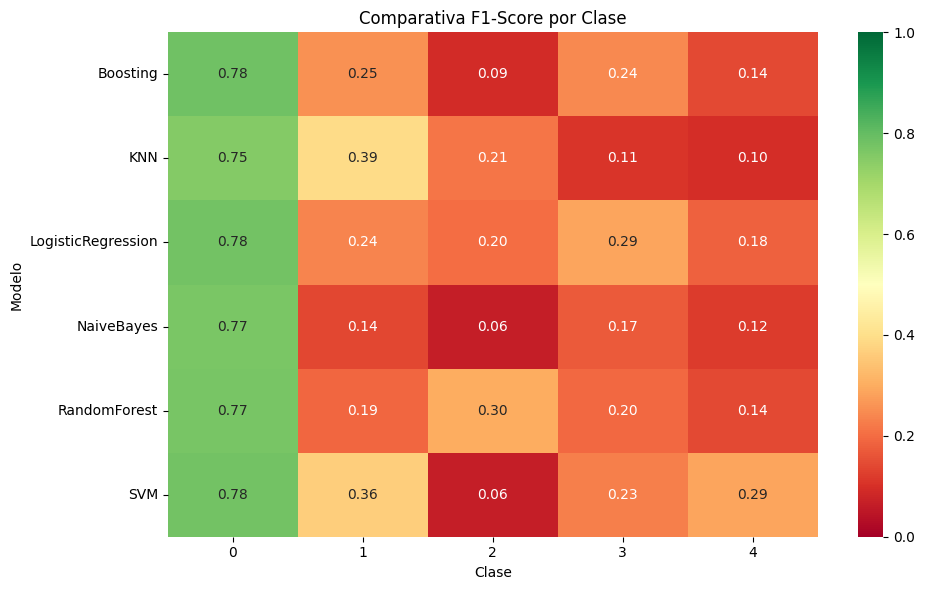

In [ ]:
class_metrics_list = []

for name, model in trained_models.items():
    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)

    # Iteramos sobre tus clases (0 a 4)
    for label in [0, 1, 2, 3, 4]:
        label_str = str(label)

        if label_str in report:
            class_metrics_list.append({
                "Model": name,
                "Class": label,
                "Precision": report[label_str]['precision'],
                "Recall": report[label_str]['recall'],
                "F1-Score": report[label_str]['f1-score'],
                "Support": report[label_str]['support']})

df_class_metrics = pd.DataFrame(class_metrics_list)

plt.figure(figsize=(10, 6))
pivot_f1 = df_class_metrics.pivot(index="Model", columns="Class", values="F1-Score")
sns.heatmap(pivot_f1, annot=True, cmap="RdYlGn", fmt=".2f", vmin=0, vmax=1)
plt.title("Comparativa F1-Score por Clase")
plt.xlabel("Clase")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

---
INSPECCIÓN DETALLADA SOBRE EL MEJOR MODELO

---


Reporte de Clasificación Detallado SVM:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        66
           1       0.34      0.39      0.36        31
           2       0.10      0.05      0.06        22
           3       0.22      0.24      0.23        21
           4       0.21      0.43      0.29         7

    accuracy                           0.49       147
   macro avg       0.33      0.37      0.34       147
weighted avg       0.48      0.49      0.48       147



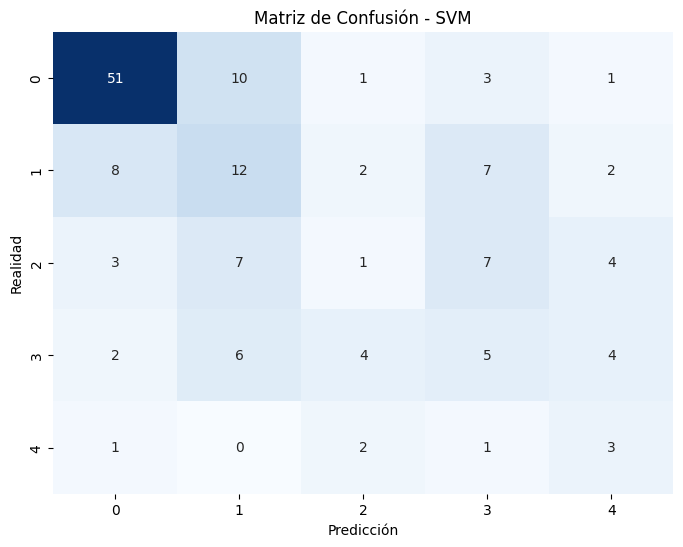

In [ ]:
best_model_row = metrics_df.sort_values("F1_micro", ascending=False).iloc[0]
best_model_name = best_model_row["Model"]
best_model = trained_models[best_model_name]

y_pred_best = best_model.predict(X_val)

print(f"\nReporte de Clasificación Detallado {best_model_name}:")
print(classification_report(y_val, y_pred_best))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.show()

# 📉 Validación Visual

La inspección visual del rendimiento por clase (Heatmap) y la Matriz de Confusión del SVM confirma la hipótesis estructural del problema.

### 4. Sanos vs. Enfermos
El mapa de calor de F1-Score muestra un patrón visual:
* **Columna 0 (Sanos):** Muestra un rendimiento sólido y consistente en todos los modelos (F1 ~0.78).
* **Columnas 1-4 (Enfermos):** El rendimiento cae drásticamente (tonos naranjas/rojos), independientemente del algoritmo. Esto confirma que los modelos aprenden a segregar la población sana, pero actúan casi por azar al intentar graduar la enfermedad.

### 5. Disección del SVM:
Aunque el SVM es el ganador global por métricas ponderadas, su comportamiento interno revela una inestabilidad crítica en los grados intermedios:

* **Polarización de Aciertos:** El SVM funciona "bien" en los extremos (Clase 0 y Clase 4 relativa al soporte), y decentemente en el inicio de la enfermedad (Clase 1), pero colapsa en el centro.
* **La clase 2 (F1-Score: 0.11):**
    * **Diagnóstico:** De 22 pacientes reales en Clase 2, el modelo solo acertó **2**.
    * **Flujo de Error:** La matriz de confusión muestra que los pacientes de Clase 2 son clasificados erróneamente como Clase 1 (9 casos) o Clase 3 (7 casos).
    * **Interpretación:** La Clase 2 carece de identidad propia en el espacio vectorial. Al estar en medio entre la 1 y la 3, y sin variables discriminantes fuertes, el SVM la absorbe en las clases vecinas.

> **Comparativa con RF/LogReg:** Mientras que RandomForest y LogisticRegression mantienen un rendimiento mediocre pero plano (equilibrado) a través de las clases enfermas, el SVM intenta maximizar los márgenes en los extremos sacrificando la clase intermedia (Clase 2), lo que le da un mejor AUC global pero lo hace inútil clínicamente para diagnosticar severidad moderada.

### 6. Conclusión Operativa
La matriz de confusión ratifica que el problema no es de potencia algorítmica (ni el mejor modelo puede resolver la Clase 2), sino de **definición del problema**.

PD:

La Robustez de la Linealidad: La Regresión Logística demostró una mayor estabilidad en las clases intermedias (Clase 2) debido a su baja varianza estructural. Al imponer una frontera de decisión lineal y probabilística, el modelo logró "suavizar" el ruido introducido por la imputación y el solapamiento de clases (variables poco discriminativas), capturando la tendencia acumulativa de los factores de riesgo (Tiers 1 y 2) mejor que modelos basados en densidad local (KNN) o márgenes estrictos (SVM), que se vieron afectados por la falta de separabilidad clara.

---
# SUBMISSION A KAGGLE

---

---
## RE-ENTRENAMIENTO CON SVM

---

In [ ]:
# Cargar datos de test y submission
# ==========================================
test = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/sample_submission.csv")

In [ ]:
# Separamos X e y del conjunto completo (Train + Val combinados)
X = df.drop(columns="label")
y = df["label"]

# Definimos las columnas especiales
cols_yeo = ["cambio_linea_corazon_ejercicio", "tension_en_descanso"]
cols_continuas = [
    "edad", "tension_en_descanso", "colesterol",
    "latidos_por_minuto", "cambio_linea_corazon_ejercicio"]

# Renombrar columnas para que coincidan con el entrenamiento
test = test.rename(columns={
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"})

# Limpieza básica del test
test = test.replace('?', np.nan)
for col in test.columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')

# IMPORTANTE: Imputar nulos en el TEST usando la mediana del TRAIN completo
# Esto evita Data Leakage y usa la estadística más robusta
for col in X.columns:
    mediana_train = X[col].median()
    test[col] = test[col].fillna(mediana_train)

# Asegurarnos de que el test tenga el mismo orden de columnas que el train
X_test_final = test[X.columns]

# ==========================================
# 3. APLICAR PREPROCESAMIENTO (Yeo-Johnson + Scaling)
# ==========================================

# A) PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Ajustamos (fit) con TODOS los datos de entrenamiento
pt.fit(X[cols_yeo])

# Transformamos entrenamiento y test con el mismo transformador
X[cols_yeo] = pt.transform(X[cols_yeo])
X_test_final[cols_yeo] = pt.transform(X_test_final[cols_yeo])

# B) StandardScaler
scaler = StandardScaler()

# Ajustamos (fit) con TODOS los datos de entrenamiento
scaler.fit(X[cols_continuas])

# Transformamos entrenamiento y test
X[cols_continuas] = scaler.transform(X[cols_continuas])
X_test_final[cols_continuas] = scaler.transform(X_test_final[cols_continuas])

# ==========================================
# 4. ENTRENAR MODELO FINAL (SVM) Y PREDECIR
# ==========================================

print("Entrenando SVM con el dataset completo...")
# Instanciamos el SVM (puedes ajustar C o kernel si hiciste optimización de hiperparámetros)
svm_final = SVC(probability=True, random_state=42)

# Entrenamos con todo X e y
svm_final.fit(X, y)

# Predecimos sobre el test procesado
y_test_pred = svm_final.predict(X_test_final)

# Verificaciones
print(f"Predicciones generadas: {len(y_test_pred)}")
print(f"Filas en sample_submission: {len(submission)}")

# ==========================================
# 5. GENERAR ARCHIVO SUBMISSION
# ==========================================
submission["label"] = y_test_pred
submission.to_csv("submission_svm_full_1.csv", index=False)

print("¡Archivo 'submission_svm_full_1.csv' guardado con éxito!")

Entrenando SVM con el dataset completo...
Predicciones generadas: 184
Filas en sample_submission: 184
¡Archivo 'submission_svm_full_1.csv' guardado con éxito!


---
## RE-ENTRENAMIENTO CON GRADIENT BOOSTING

---

In [ ]:
# Cargar datos de test y submission
# ==========================================
test = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/sample_submission.csv")

In [ ]:
# Separamos X e y del conjunto completo (Train + Val combinados)
X = df.drop(columns="label")
y = df["label"]

# Definimos las columnas especiales
cols_yeo = ["cambio_linea_corazon_ejercicio", "tension_en_descanso"]
cols_continuas = [
    "edad", "tension_en_descanso", "colesterol",
    "latidos_por_minuto", "cambio_linea_corazon_ejercicio"]

# Renombrar columnas para que coincidan con el entrenamiento
test = test.rename(columns={
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"})

# Limpieza básica del test
test = test.replace('?', np.nan)
for col in test.columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')

# IMPORTANTE: Imputar nulos en el TEST usando la mediana del TRAIN completo
# Esto evita Data Leakage y usa la estadística más robusta
for col in X.columns:
    mediana_train = X[col].median()
    test[col] = test[col].fillna(mediana_train)

# Asegurarnos de que el test tenga el mismo orden de columnas que el train
X_test_final = test[X.columns]

# ==========================================
# 3. APLICAR PREPROCESAMIENTO (Yeo-Johnson + Scaling)
# ==========================================

# A) PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Ajustamos (fit) con TODOS los datos de entrenamiento
pt.fit(X[cols_yeo])

# Transformamos entrenamiento y test con el mismo transformador
X[cols_yeo] = pt.transform(X[cols_yeo])
X_test_final[cols_yeo] = pt.transform(X_test_final[cols_yeo])

# B) StandardScaler
scaler = StandardScaler()

# Ajustamos (fit) con TODOS los datos de entrenamiento
scaler.fit(X[cols_continuas])

# Transformamos entrenamiento y test
X[cols_continuas] = scaler.transform(X[cols_continuas])
X_test_final[cols_continuas] = scaler.transform(X_test_final[cols_continuas])

# ==========================================
# 4. ENTRENAR MODELO FINAL (BOOSTING) Y PREDECIR
# ==========================================

print("Entrenando boosting con el dataset completo...")
boost_final = GradientBoostingClassifier(random_state=42)

# Entrenamos con todo X e y
boost_final.fit(X, y)

# Predecimos sobre el test procesado
y_test_pred = boost_final.predict(X_test_final)

# Verificaciones
print(f"Predicciones generadas: {len(y_test_pred)}")
print(f"Filas en sample_submission: {len(submission)}")

# ==========================================
# 5. GENERAR ARCHIVO SUBMISSION
# ==========================================
submission["label"] = y_test_pred
submission.to_csv("submission_svm_full_2.csv", index=False)

print("¡Archivo 'submission_svm_full_2.csv' guardado con éxito!")

Entrenando SVM con el dataset completo...
Predicciones generadas: 184
Filas en sample_submission: 184
¡Archivo 'submission_svm_full_2.csv' guardado con éxito!


---
## RE-ENTRENAMIENTO CON REGRESIÓN LOGÍSTICA

---

In [ ]:
# Cargar datos de test y submission
# ==========================================
test = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/sample_submission.csv")

In [ ]:
# ==========================================
# 1. PREPARACIÓN DEL TRAIN (df)
# ==========================================
# Asumimos que df está cargado.
# PRIMERO: Renombramos df al español para que coincida con tus listas
mapa_nombres = {
    "age": "edad", "sex": "sexo", "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso", "chol": "colesterol",
    "fbs": "azucar", "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto", "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio", "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes", "thal": "estado_corazon_thal"
}
df = df.rename(columns=mapa_nombres)

# SEGUNDO: Limpieza de valores sucios en TRAIN (igual que harás en test)
# Si hay -9 en el train, distorsionan la media/mediana. ¡Hay que quitarlos!
df = df.replace(['?', -9, -9.0, '-9', '-9.0'], np.nan)

# TERCERO: Convertir todo a numérico en TRAIN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# CUARTO: Ahora sí, definimos X e y (con los datos limpios y en español)
X = df.drop(columns="label")
y = df["label"]

# ==========================================
# 2. DEFINICIÓN DE LISTAS (En español)
# ==========================================
cols_yeo = ["cambio_linea_corazon_ejercicio", "tension_en_descanso"]

cols_continuas = [
    "edad", "tension_en_descanso", "colesterol",
    "latidos_por_minuto", "cambio_linea_corazon_ejercicio"
]

cols_categoricas = [
    "sexo", "tipo_dolor_pecho", "azucar", "electro_en_descanso",
    "dolor_pecho_con_ejercicio", "forma_linea_corazon_ejercicio",
    "num_venas_grandes", "estado_corazon_thal"
]

# ==========================================
# 3. PREPARACIÓN DEL TEST
# ==========================================
# Renombrar Test (usamos el mismo mapa que arriba)
test = test.rename(columns=mapa_nombres)

# Limpieza de valores sucios en Test
test = test.replace(['?', -9, -9.0, '-9', '-9.0'], np.nan)

# Convertir a numérico
for col in test.columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')

# ==========================================
# 4. IMPUTACIÓN (Usando estadísticas de X limpio)
# ==========================================

# 4.1. Imputar numéricas con la MEDIANA del Train
for col in cols_continuas:
    if col in X.columns:
        mediana_train = X[col].median()
        test[col] = test[col].fillna(mediana_train)
        # Opcional: También imputar en X si X tenía nulos originalmente
        X[col] = X[col].fillna(mediana_train)

# 4.2. Imputar categóricas con la MODA del Train
for col in cols_categoricas:
    if col in X.columns:
        # mode() devuelve una serie, tomamos el primer valor [0]
        # dropna=True es default, así que ignora los NaNs para calcular la moda
        moda_train = X[col].mode()[0]
        test[col] = test[col].fillna(moda_train)
        # Opcional: También imputar en X
        X[col] = X[col].fillna(moda_train)

# ==========================================
# 5. ALINEACIÓN FINAL
# ==========================================
# Asegurarnos de que el test tenga exactamente las mismas columnas y orden que X
X_test_final = test[X.columns]

if 'num_venas_grandes' in X_test_final.columns:
    # Calculamos la moda (valor más común) del train para imputar
    moda_venas = X['num_venas_grandes'].mode()[0]

    # Reemplazamos el 9.0 por la moda
    X_test_final['num_venas_grandes'] = X_test_final['num_venas_grandes'].replace(9.0, moda_venas)
    X_test_final['num_venas_grandes'] = X_test_final['num_venas_grandes'].replace(9, moda_venas) # Por si es entero

    print(f"Limpieza completada: Se reemplazaron valores '9' en venas por la moda: {moda_venas}")


print("¡Datos procesados correctamente!")
print("Columnas en X:", X.shape)
print("Columnas en Test:", X_test_final.shape)
# Verifica que no queden negativos raros
print("Mínimos en Test:\n", X_test_final.max())

Limpieza completada: Se reemplazaron valores '9' en venas por la moda: 0.0
¡Datos procesados correctamente!
Columnas en X: (732, 13)
Columnas en Test: (184, 13)
Mínimos en Test:
 edad                               77.0
sexo                                1.0
tipo_dolor_pecho                    4.0
tension_en_descanso               200.0
colesterol                        407.0
azucar                              1.0
electro_en_descanso                 2.0
latidos_por_minuto                188.0
dolor_pecho_con_ejercicio           1.0
cambio_linea_corazon_ejercicio      4.0
forma_linea_corazon_ejercicio       3.0
num_venas_grandes                   3.0
estado_corazon_thal                 7.0
dtype: float64


In [ ]:
# ==========================================
# 3. APLICAR PREPROCESAMIENTO (Yeo-Johnson + Scaling)
# ==========================================

# A) PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Ajustamos (fit) con TODOS los datos de entrenamiento
pt.fit(X[cols_yeo])

# Transformamos entrenamiento y test con el mismo transformador
X[cols_yeo] = pt.transform(X[cols_yeo])
X_test_final[cols_yeo] = pt.transform(X_test_final[cols_yeo])

# B) StandardScaler
scaler = StandardScaler()

# Ajustamos (fit) con TODOS los datos de entrenamiento
scaler.fit(X[cols_continuas])

# Transformamos entrenamiento y test
X[cols_continuas] = scaler.transform(X[cols_continuas])
X_test_final[cols_continuas] = scaler.transform(X_test_final[cols_continuas])


In [ ]:
# ==========================================
# 4. ENTRENAR MODELO FINAL (REG LOGÍSTICA) Y PREDECIR
# ==========================================

print("Entrenando regresión logística con el dataset completo...")
reglog_final = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')

# Entrenamos con todo X e y
reglog_final.fit(X, y)

# Predecimos sobre el test procesado
y_test_pred = boost_final.predict(X_test_final)

# Verificaciones
print(f"Predicciones generadas: {len(y_test_pred)}")
print(f"Filas en sample_submission: {len(submission)}")

# ==========================================
# 5. GENERAR ARCHIVO SUBMISSION
# ==========================================
submission["label"] = y_test_pred
submission.to_csv("submission_svm_full_3.csv", index=False)

print("¡Archivo 'submission_svm_full_3.csv' guardado con éxito!")

Entrenando regresión logística con el dataset completo...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Predicciones generadas: 184
Filas en sample_submission: 184
¡Archivo 'submission_svm_full_3.csv' guardado con éxito!


---
## RE-ENTRENAMIENTO CON BOOSTING CLASSIFIER

---

In [ ]:
# Cargar datos de test y submission
# ==========================================
test = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Cupido_IA_project/sample_submission.csv")

In [ ]:
# ==========================================
# 1. PREPARACIÓN DEL TRAIN (df)
# ==========================================
# Asumimos que df está cargado.
# PRIMERO: Renombramos df al español para que coincida con tus listas
mapa_nombres = {
    "age": "edad", "sex": "sexo", "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso", "chol": "colesterol",
    "fbs": "azucar", "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto", "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio", "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes", "thal": "estado_corazon_thal"
}
df = df.rename(columns=mapa_nombres)

# SEGUNDO: Limpieza de valores sucios en TRAIN (igual que harás en test)
# Si hay -9 en el train, distorsionan la media/mediana. ¡Hay que quitarlos!
df = df.replace(['?', -9, -9.0, '-9', '-9.0'], np.nan)

# TERCERO: Convertir todo a numérico en TRAIN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# CUARTO: Ahora sí, definimos X e y (con los datos limpios y en español)
X = df.drop(columns="label")
y = df["label"]

# ==========================================
# 2. DEFINICIÓN DE LISTAS (En español)
# ==========================================
cols_yeo = ["cambio_linea_corazon_ejercicio", "tension_en_descanso"]

cols_continuas = [
    "edad", "tension_en_descanso", "colesterol",
    "latidos_por_minuto", "cambio_linea_corazon_ejercicio"
]

cols_categoricas = [
    "sexo", "tipo_dolor_pecho", "azucar", "electro_en_descanso",
    "dolor_pecho_con_ejercicio", "forma_linea_corazon_ejercicio",
    "num_venas_grandes", "estado_corazon_thal"
]

# ==========================================
# 3. PREPARACIÓN DEL TEST
# ==========================================
# Renombrar Test (usamos el mismo mapa que arriba)
test = test.rename(columns=mapa_nombres)

# Limpieza de valores sucios en Test
test = test.replace(['?', -9, -9.0, '-9', '-9.0'], np.nan)

# Convertir a numérico
for col in test.columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')

# ==========================================
# 4. IMPUTACIÓN (Usando estadísticas de X limpio)
# ==========================================

# 4.1. Imputar numéricas con la MEDIANA del Train
for col in cols_continuas:
    if col in X.columns:
        mediana_train = X[col].median()
        test[col] = test[col].fillna(mediana_train)
        # Opcional: También imputar en X si X tenía nulos originalmente
        X[col] = X[col].fillna(mediana_train)

# 4.2. Imputar categóricas con la MODA del Train
for col in cols_categoricas:
    if col in X.columns:
        # mode() devuelve una serie, tomamos el primer valor [0]
        # dropna=True es default, así que ignora los NaNs para calcular la moda
        moda_train = X[col].mode()[0]
        test[col] = test[col].fillna(moda_train)
        # Opcional: También imputar en X
        X[col] = X[col].fillna(moda_train)

# ==========================================
# 5. ALINEACIÓN FINAL
# ==========================================
# Asegurarnos de que el test tenga exactamente las mismas columnas y orden que X
X_test_final = test[X.columns]

if 'num_venas_grandes' in X_test_final.columns:
    # Calculamos la moda (valor más común) del train para imputar
    moda_venas = X['num_venas_grandes'].mode()[0]

    # Reemplazamos el 9.0 por la moda
    X_test_final['num_venas_grandes'] = X_test_final['num_venas_grandes'].replace(9.0, moda_venas)
    X_test_final['num_venas_grandes'] = X_test_final['num_venas_grandes'].replace(9, moda_venas) # Por si es entero

    print(f"Limpieza completada: Se reemplazaron valores '9' en venas por la moda: {moda_venas}")


print("¡Datos procesados correctamente!")
print("Columnas en X:", X.shape)
print("Columnas en Test:", X_test_final.shape)
# Verifica que no queden negativos raros
print("Mínimos en Test:\n", X_test_final.max())

Limpieza completada: Se reemplazaron valores '9' en venas por la moda: 0.0
¡Datos procesados correctamente!
Columnas en X: (732, 13)
Columnas en Test: (184, 13)
Mínimos en Test:
 edad                               77.0
sexo                                1.0
tipo_dolor_pecho                    4.0
tension_en_descanso               200.0
colesterol                        407.0
azucar                              1.0
electro_en_descanso                 2.0
latidos_por_minuto                188.0
dolor_pecho_con_ejercicio           1.0
cambio_linea_corazon_ejercicio      4.0
forma_linea_corazon_ejercicio       3.0
num_venas_grandes                   3.0
estado_corazon_thal                 7.0
dtype: float64


In [ ]:
# ==========================================
# 3. APLICAR PREPROCESAMIENTO (Yeo-Johnson + Scaling)
# ==========================================

# A) PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Ajustamos (fit) con TODOS los datos de entrenamiento
pt.fit(X[cols_yeo])

# Transformamos entrenamiento y test con el mismo transformador
X[cols_yeo] = pt.transform(X[cols_yeo])
X_test_final[cols_yeo] = pt.transform(X_test_final[cols_yeo])

# B) StandardScaler
scaler = StandardScaler()

# Ajustamos (fit) con TODOS los datos de entrenamiento
scaler.fit(X[cols_continuas])

# Transformamos entrenamiento y test
X[cols_continuas] = scaler.transform(X[cols_continuas])
X_test_final[cols_continuas] = scaler.transform(X_test_final[cols_continuas])


In [ ]:
# ==========================================
# 4. ENTRENAR MODELO FINAL (boosting classifier) Y PREDECIR
# ==========================================

print("Entrenando boosting classifier con el dataset completo...")
boost_final = GradientBoostingClassifier(
    n_estimators=100,      # Número de árboles (100 es el estándar robusto)
    learning_rate=0.1,     # Velocidad de aprendizaje (0.1 es el estándar)
    max_depth=3,           # Profundidad máxima de cada árbol (evita sobreajuste)
    random_state=42        # Para reproducibilidad
)

# Entrenamos con todo X e y
boost_final.fit(X, y)

# Predecimos sobre el test procesado
y_test_pred = boost_final.predict(X_test_final)

# Verificaciones
print(f"Predicciones generadas: {len(y_test_pred)}")
print(f"Filas en sample_submission: {len(submission)}")

# ==========================================
# 5. GENERAR ARCHIVO SUBMISSION
# ==========================================
submission["label"] = y_test_pred
submission.to_csv("submission_svm_full_4.csv", index=False)

print("¡Archivo 'submission_svm_full_4.csv' guardado con éxito!")

Entrenando boosting classifier con el dataset completo...
Predicciones generadas: 184
Filas en sample_submission: 184
¡Archivo 'submission_svm_full_4.csv' guardado con éxito!


---

## DOCUMENTACIÓN

---

El objetivo de esta fase inicial fue establecer un *benchmark* y diagnosticar el comportamiento de los datos. Contrario a la intuición inicial, los modelos complejos fallaron ante el ruido, mientras que la simplicidad lineal prevaleció.

### 1. ⚙️ Preprocesamiento y Experimentación
* **Transformaciones:** Se aplicó `PowerTransformer` (Yeo-Johnson) para normalizar distribuciones y `StandardScaler`.
* **Fallo del SVM (Lección Aprendida):** El SVM obtuvo el peor resultado (**0.358**).
    * *Diagnóstico:* Al usar `StandardScaler` sin una limpieza agresiva de outliers (*clipping*), el SVM fue incapaz de generalizar. Esto confirma que este algoritmo requiere una higiene de datos impecable o escaladores robustos (RobustScaler) para funcionar en este dataset.
* **Fallo del SMOTE:** El balanceo sintético introdujo más ruido que señal, por lo que se descartó para los entrenamientos finales.

### 2. 🏆 Resultados en Kaggle
Los resultados del revelaron que la relación entre las variables y la enfermedad tiene un componente lineal muy fuerte que los modelos complejos no logran superar en esta etapa cruda.

* **🥇 Regresión Logística (0.50543):** El mejor modelo (archivo `...full_3.csv`). Su simplicidad actuó como un filtro natural contra el ruido, capturando la tendencia general de los factores de riesgo mejor que nadie.
* **🥈 Gradient Boosting (0.50543):** Empató en score máximo en su segunda configuración (`...full_4.csv`), demostrando que los árboles pueden manejar el ruido mejor que el SVM, pero sin superar a la regresión lineal.
* **❌ SVM (0.35869):** El rendimiento fue deficiente, validando la necesidad de iterar sobre el preprocesado específico para modelos geométricos.

### 3. 🔍 Diagnóstico Crítico: El Problema de la Severidad
Independientemente del modelo, el análisis de la matriz de confusión mostró el obstáculo estructural:
* **Éxito Binario:** Todos distinguen razonablemente bien entre Sano vs. Enfermo.
* **Agujero Negro (Clase 2):** Ningún modelo logró identificar correctamente la enfermedad de grado moderado (Clase 2), confundiéndola sistemáticamente con grados 1 o 3.

### 4. 📉 Conclusión de la Iteración
La **Regresión Logística** ha establecido el techo a batir (**0.505**). El hecho de que un modelo lineal simple supere a modelos complejos indica que **la calidad de los datos (ruido/outliers) es el cuello de botella actual**.
* *Próximo paso:* Abandonar la complejidad del modelo y centrarse en la limpieza del dato (Robust Scaling, Clipping) para intentar \"resucitar\" al SVM en la siguiente iteración.